# Analysis for Deep Learning, deep change? 

This notebook analyses a dataset of Arxiv papers for our Deep learning paper. 

**Activities**

* Load the data
* Initial exploration
* Produce a couple of charts for the AI Index including:
   * Trends in papers within AI related domains
   * Relative importance of DL, focusing on categories of interest (computer vision and natural language vs learning and stats)
   
* Carry out mapping analysis



## 0. Preamble

In [86]:
%matplotlib inline

#Some imports
import matplotlib.patches as mpatches

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


## 1. Load data

We are going to work with data which have classified DL papers based on different strategies and compare results for robustness. Write a pipeiline that does this automatically


In [312]:
# Initial exploration before writing the pipeline

papers = pd.read_json(ext_data+'/CsDl_CorExCompoundsFull_MakGridMatched_withCountries.json',orient='records')

papers.shape

(116730, 19)

There are 116,730 papers. This is the total number of CS + Stats papers in Arxiv?

In [313]:
#Let's check the variables
papers.head()

,arxiv_cat,arxiv_id,categories,cex_isDL_1,cex_isDL_1.5,citations,cities,city,codes,countries,date,institutes,lat_lon_score,lda_isDL,matched,pid,publication_year,summary,title
0,cs.NE,704.0047,"[cs.NE, cs.AI]",False,False,8.0,[Ljubljana],NaN,[SI],[Slovenia],1.041466e+12,[university of ljubljana],"[[46.049268, 14.505099, 1.0]]",False,True,http://arxiv.org/abs/0704.0047v1,2007,"[intelligent, acoustic, emission, locator, des...",intelligent location of simultaneously active ...
1,cs.NE,704.0050,"[cs.NE, cs.AI]",False,False,0.0,[Ljubljana],NaN,[SI],[Slovenia],1.175386e+12,[university of ljubljana],"[[46.049268, 14.505099, 1.0]]",False,True,http://arxiv.org/abs/0704.0050v1,2007,"[part, describes, intelligent, acoustic, emiss...",intelligent location of simultaneously active ...
2,cs.DS,704.0062,[cs.DS],False,False,NaN,[],NaN,[],[],NaN,None,[],False,False,http://arxiv.org/abs/0704.0062v1,2007,"[paper, introduce, line, viterbi, algorithm, d...",on line viterbi algorithm and its relationship...
3,cs.CE,704.0090,"[cs.CE, cond-mat.stat-mech, cs.MS, cs.NA, phys...",False,False,NaN,[],NaN,[],[],NaN,None,[],False,False,http://arxiv.org/abs/0704.0090v1,2007,"[real, option, project, schedule, rops, ha, th...",real options for project schedules rops
4,cs.CC,704.0108,[cs.CC],False,False,0.0,[],NaN,[],[],1.175386e+12,[],[],False,True,http://arxiv.org/abs/0704.0108v1,2007,"[description, polynomial, time, reduction, sat...",reducing sat to 2 sat


In [314]:
#Tidy the variable names
papers.columns = ['category','id','categories','is_dl_cex1','is_dl_cex15','citations',
                  'cities','city','codes','countries',
                  'date','organisations','lat_lon','is_dl_lda','mak_match','abstract','year',
                  'summary','title']

### Plot paper trends

I will write a class to do this. 

The class takes a json file and a Deep Learning flags.

We use its methods to:

* Plot trends in DL compared to the total (also with a filter that focuses on highly cited papers in the period
* Plot trends in DL by subcategory compared to the total (also with a highly cited filter)
* Plot totals in DL-heavy topics
* Extract top keywords by category and year.

In [379]:
class dlPaperAnalysis():
    '''
    The class takes a json file and a Deep Learning flags.
    -We use its methods to:
        -Plot trends in DL compared to the total 
        (also with a filter that focuses on highly cited papers in the period
        -Plot trends in DL by subcategory compared to the total (also with a highly cited filter)
        -Plot totals in DL-heavy topics
        -Extract top keywords by category and year.
    
    '''
    
    def __init__(self,file,variable):
        '''
        Initialise the class with a file and a variable to flag dl papers. This 
        can be the different files we have previously used in our analysis
        
        '''
        
        self.papers = file
        self.dl_flag = variable
        self.flag_short = variable.split("_")[-1]
         
        
    def generate_total_report(self):
        '''
        This generates a df with the total number of DL papers 
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Load the flag
        flag = self.dl_flag
        
        #Generate paper counts
        dl_counts = papers[flag].value_counts()
        
        #Concatenate with shares
        dl_counts_shares = pd.concat([dl_counts,100*dl_counts/dl_counts.sum()],axis=1)
        
        dl_counts_shares.columns = [self.flag_short+'_count',self.flag_short+'_pc']
        
        self.dl_totals= dl_counts_shares
        
    def generate_year_reports(self):
        '''
        This generates a df with DL papers by year, and their share of the total
        
        '''
        #Load papers
        papers = self.papers
        
        #Load the flag
        flag = self.dl_flag     
        
        
        #Cross tabs
        timelines = make_crosstab(papers,'year',flag)
        
        
        #Store
        self.year_count = timelines[0]
        self.year_share = timelines[1]
        
    def generate_cat_reports(self,num=10):
        '''
        
        This generates a df with DL papers by cat and their share of the total
        
        '''
        
        #Load papers
        papers = self.papers
        flag = self.dl_flag
        
        #Generate and store a ranking of categories based on importance
        self.top_cats = papers.category.value_counts().index[:num]
        
        
        #Cross tab by category
        categories = make_crosstab(papers,'category',flag)
        
        #Store
        self.cat_count = categories[0]
        self.cat_share = categories[1]
        
        #Also store the top DL categories
        self.top_dl_cats = categories[0].sort_values(categories[0].columns[1],ascending=False)[:num]
        
        
    
    def generate_cat_years_reports(self):
        '''
        This generates, for each category, dl year counts and value counts
        
        
        '''
        
        #Initialise everything
        papers = self.papers
        flag = self.dl_flag
        
        #Dictionaries that stores counts and shares of papers in a category
        cats_store_count = {}
        cats_store_share = {}
        
        for x in set(papers.category):
            
            #Papers in category
            papers_selected = papers.loc[papers.category==x,:]
            
            timelines = make_crosstab(papers_selected,'year',flag)
            
            #Store
            cats_store_count[x] = timelines[0]
            cats_store_share[x] = timelines[1]
        
        #Store
        self.category_dl_counts = cats_store_count
        self.category_dl_shares = cats_store_share
            
            
    def plot_categories(self,ax=None,share=False,num=10):
        '''
        Plot the levels of dl activity by category (not considering time)
        
        #Num determines the number of categories to plot
        
        '''
        
        #This is to sort the data by the top categories
        focus_categories = self.cat_count.sum(axis=1).sort_values(ascending=False).index[:num]
        
        if share==False:
            data = self.cat_count.iloc[:,[1,0]]
            data_sorted = data.loc[focus_categories,:]
            
            data_sorted.plot.bar(ax=ax,
                                 title="Number of papers by Arxiv category and DL \n according to {x} definition".format(x=self.flag_short),
                                colors=['darkorange','darkblue'])
            
        else:
            
            data = self.cat_share.iloc[:,[1,0]]
            
            data_sorted = data.loc[focus_categories,:]
            
            data_sorted.plot.bar(ax=ax,stacked=True,
                                title="Share of DL papers in Arxiv category \n according to {x} definition".format(x=self.flag_short),
                                colors=['darkorange','darkblue'])
        
        
        
    
    
    
    def plot_years(self,ax=None,category='all',stacked=False):
        '''
        Returns a linechart
        
        '''
        
        #If we want to plot all, we use year count. Otherwise we look for the right count below.
        
        #If we want to plot all do it this way.
        if category=='all':
            
            #If we want a linechart
            if stacked==False:
                data= self.year_count
                
                data.plot(title='Levels of Arxiv and DL activity \n according to {x} definition'.format(x=self.flag_short),
                                ax=ax,color=['darkblue','darkorange'])
                
            #If we want a stacked plot
            else:
                data = self.year_share.iloc[:,[1,0]]
                data.plot.bar(title='Shares DL activity \n according to {x} definition'.format(
                    x=self.flag_short),ax=ax,stacked=True,color=['darkorange','darkblue'])
            
        #This starts to get a bit more complicated
        else:
            
            #Again, it depends on whether we want to stack or not
            
            if stacked==False:   
                #Extract and subset papers                
                data= self.category_dl_counts[category]
            
                data.plot(
                    title='Levels of Arxiv and DL activity in category {cat} \n according to {x} definition'.format(
                        x=self.flag_short,cat=category),ax=ax,color=['darkblue','darkorange'])
            
            
            else:
                #Extract share data
                data = self.category_dl_shares[category].iloc[:,[1,0]]
                
                data.plot.bar(title='Shares DL activity in category {cat} \n according to {x} definition'.format(
                    x=self.flag_short,cat=category),ax=ax,stacked=True,color=['darkorange','darkblue'])
                
            
        
        

In [380]:
def make_crosstab(df,category,flag,ct=False):
    '''
    Takes a df and creates a timeline (year count)
    
    '''
    
    dl = pd.crosstab(df[category],df[flag])
    dl_norm = pd.crosstab(df[category],df[flag],normalize=0)
        
    #Add names with the flag identifier
    var_names = ['not_dl_'+flag.split("_")[-1],'dl_'+flag.split("_")[-1]]
        
    #Rename the dfs (we add len in case there are categories with no DL papers)
    dl.columns=var_names[:len(dl.columns)]
    dl_norm.columns = var_names[:len(dl.columns)]

    return([dl,dl_norm])
    

In [381]:
def generate_all_reports(df,flag):
    '''
    Takes a flag for DL papers and runs all the methods in the class above

    '''

    init_class = dlPaperAnalysis(df,flag)

    init_class.generate_total_report()

    init_class.dl_totals

    init_class.generate_year_reports()

    init_class.generate_cat_reports()

    init_class.generate_cat_years_reports()

    return(init_class)

In [395]:
dl_ces1_class = generate_all_reports(papers,flag='is_dl_cex1')

In [410]:
def prettify_all_trends(read_class,title_addition=None):
    '''
    This function prettifies the trends charts for all papers.
    
    '''
    
    fig,ax = plt.subplots(figsize=(7,7),nrows=2)

    read_class.plot_years(ax=ax[0],category='all')
    read_class.plot_years(ax=ax[1],category='all',stacked=True)


    #Prettify
    ax[0].get_xaxis().set_visible(False)
    ax[1].get_legend().set_visible(False)

    ax[0].legend(labels=['Non Deep Learning papers','Deep Learning papers'],title='Paper classification')

    #Change titles
    
    if title_addition==None:
        ax[0].set_title('Levels of activity in Arxiv by classification outcome \n (Number of papers and shares of total)')
    
    else:
        ax[0].set_title(
            'Levels of activity in Arxiv by classification outcome \n (Number of papers and shares of total) - {x}'.format(
            x=title_addition))
    
    ax[1].set_title('')


    plt.subplots_adjust(hspace=0)
    
    

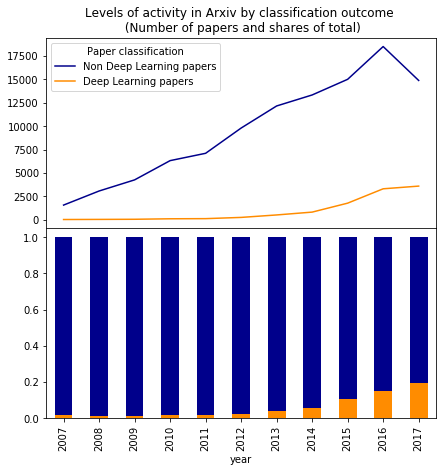

In [411]:
prettify_all_trends(dl_ces1_class)

### Plot papers by Arxiv category

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


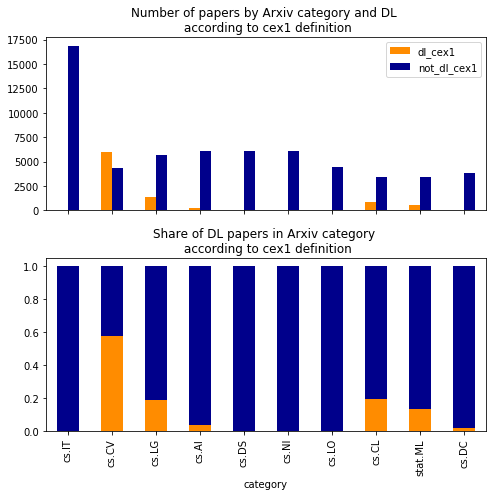

In [436]:
fig,ax = plt.subplots(figsize=(7,7),nrows=2,sharex=True)

dl_ces1_class.plot_categories(ax=ax[0])
dl_ces1_class.plot_categories(ax=ax[1],share=True)

ax[1].get_legend().set_visible(False)

plt.tight_layout()

### Plot paper trends by subcategory

In [417]:
def prettify_subcat_trends(read_class,title_addition=None,areas=dl_areas):
    '''
    Prettifies the year plots based on categories
    Title addition adds something to the title to clarify results
    areas selects the areas to visualsie
    
    '''
    
    fig,ax = plt.subplots(nrows=10,ncols=2,figsize=(10,12),sharex='col')

    for num,x in enumerate(areas):
        #Line chart
        read_class.plot_years(category=x,ax=ax[num][0])

        #Stack
        read_class.plot_years(category=x,ax=ax[num][1],stacked=True)


        #Remove legends and titles
        ax[num][0].set_title(x+': Total papers')
        ax[num][1].set_title(x+': Share of total')

        ax[num][1].hlines(y=0.5,xmin=-0.5,xmax=11,color='white')

        #[ax[num][val].set_title('') for val in [0,1]]
        [ax[num][val].get_legend().set_visible(False) for val in [0,1]]
    
    
    if title_addition==None:
        fig.suptitle('Levels and shares of Arxiv activity by category',y=1.02)
    else:
        fig.suptitle('Levels and shares of Arxiv activity by category - {x}'.format(x=title_addition))
    
    plt.tight_layout()

    
    

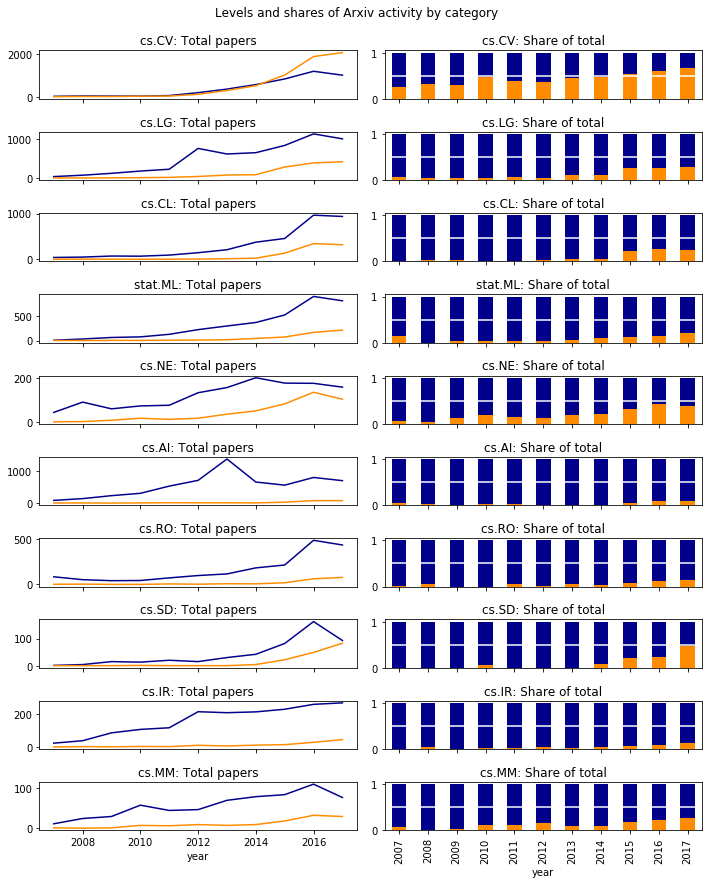

In [418]:
prettify_subcat_trends(dl_ces1_class)

### Are these things robust to more stringent selection?

We will group by year and only focus on the top 25 papers each year in terms of citations. Is the advent of DL still visible?



In [419]:
#Top percentile of highly cited papers
year_quartile_citations = papers.groupby('year')['citations'].quantile(0.99)

#Which ones are they?
papers['highly_cited'] = [x>year_quartile_citations[y] for x,y in zip(papers.citations,papers.year)]

#Subset the data
papers_highly_cited = papers.loc[papers.highly_cited==True,:]

#Process with the previous definition
dl_ces1_cited_class = generate_all_reports(papers_highly_cited,flag='is_dl_cex1')

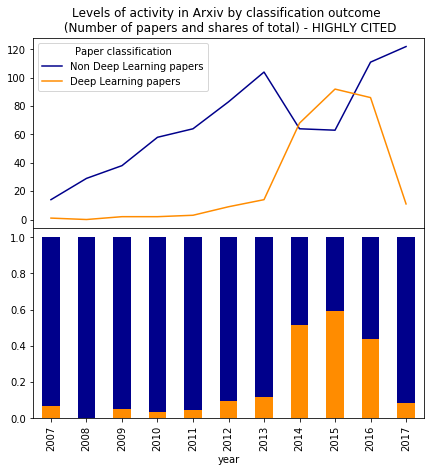

In [420]:
#Plot pretty

prettify_all_trends(dl_ces1_cited_class,title_addition='HIGHLY CITED')


/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


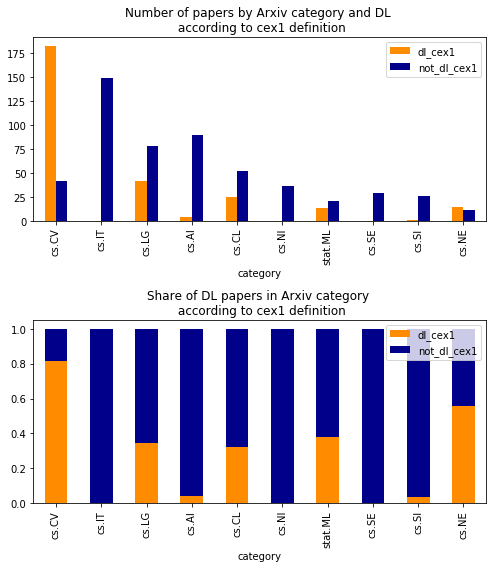

In [426]:
#Top cited by area

fig,ax = plt.subplots(figsize=(7,8),nrows=2)

dl_ces1_cited_class.plot_categories(ax=ax[0])
dl_ces1_cited_class.plot_categories(ax=ax[1],share=True)

plt.tight_layout()

### Plot activity by category separating DL intensive and non DL intensive domains

In [437]:
#Domains with some DL activity
dl_areas = dl_ces1_class.cat_count.sort_values('dl_cex1',ascending=False).index[:10]

/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:521: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


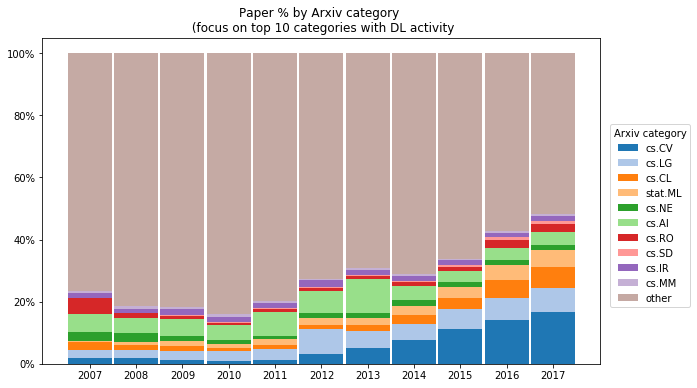

In [454]:
# Plot activity by category - 

papers['categories_big'] = [x if x in dl_areas else 'other' for x in papers.category]


cats_year = pd.crosstab(papers.year,papers.categories_big,normalize=0).loc[:,list(dl_areas)+['other']]

#Old school barchart

colors = plt.cm.get_cmap('tab20').colors[:len(cats_year.columns)]

color_lookup = {x:y for x,y in zip(cats_year.columns,colors)}

fig,ax = plt.subplots(figsize=(10,6))

bottom = np.array([0]*len(cats_year))

for x in cats_year.columns:
    ax.bar(np.arange(len(cats_year)),
           height=cats_year[x],
           bottom=bottom,
           color=color_lookup[x],width=0.95,
           alpha=1 if x !='other' else 0.5
          )
    
    
    bottom = bottom+cats_year[x]

ax.set_xticks(np.arange(len(cats_year.index)))
ax.set_xticklabels(cats_year.index)
ax.set_title('Paper % by Arxiv category \n (focus on top 10 categories with DL activity')

la = ax.get_yticklabels()

ax.set_yticklabels([str(int(100*x))+'%' for x in np.arange(0,1.1,0.2)])


patches = [mpatches.Patch(color=c,label=l) for l,c in color_lookup.items()]

ax.legend(patches,
          labels=cats_year.columns,bbox_to_anchor=(1.17,0.75),title='Arxiv category')